Notebook to compute CLs for the analysis, including: galaxy clustering of QUAIA QSOs (GG), CIB (cc) and lensing data (kk)

In [ ]:
## CIB MAP: highest frequency ##
nside = 512
map_c = hp.read_map(dir + 'cib_map_rot.fits')
# hp.mollview(map_c, title = len(map_c))
mask_c = hp.read_map(dir + 'cib_mask_rot.fits')
# hp.mollview(mask_c, title = len(map_c))
print(np.isnan(mask_c).sum(), np.isnan(map_c).sum())

## down-sizing ##
map_c = hp.ud_grade(map_c, nside)
mask_c[mask_c<=0.5] = 0
mask_c[mask_c>0.5] = 1
mask_c = hp.ud_grade(mask_c, nside)
print(len(map_c))
print(np.isnan(mask_c).sum(), np.isnan(map_c).sum())

lmax = 3*nside
fwhm = 5
bl = hp.gauss_beam(np.radians(fwhm/60.), lmax = lmax)
cc = nmt.NmtField(mask_c, [map_c], beam = bl)

In [ ]:
## LENSING MAP AND MASK, NB the maps is obtained with pol-only ##
map_l = hp.read_map(dir  + 'kappa_ns512_rotated_PR4Truep_p.fits')
mask_l = hp.read_map(dir + 'mask_kappa_ns512_rotated_PR4Truep_p.fits')
kk = nmt.NmtField(mask_l, [map_l], n_iter=0)

In [ ]:
## GALAXY MAPS and MASKS from quaia catalog. 3 galaxy bins. NB the same selection function is used for bin2 and bin3 ##
nbins = 3
Asn_prior = None
magcut = "20.5"
nz_spec = False
if nz_spec:
    nz_suff = '_nzhist'
    num_z_bins = 100
else:
    nz_suff = ''
    num_z_bins = 500

# Read full catalog and calculate edges for the number of bins
config = {'nside': nside, 'num_z_bins': num_z_bins, 'z_edges': [0.0, 5.0],
          'data_catalog': dir + f"/quaia_G{magcut}.fits",
          'selection': dir + f"/selection_function_NSIDE64_G{magcut}.fits",
          'mask_threshold': 0.5, 'coords': 'C', 'nz_spec': nz_spec}
mp = xcl.mappers.MapperGAIAQSO(config)
cat = mp.get_catalog()
zs = sorted(cat['redshift_quaia'])
z_edges = [0, 1, 2.5, 5]  ##z_edges for three bins: no need to be equi-populated##


maps = {}
masks = {}
nzs = {}
fgs = {}
pnl = {}
n = ['0', '1', '1']                     ## use the same selection function for both 2-3 bin ##
for i in range(nbins):
    print(i+1)
    if nbins == 1:
        selname = dir + f"/selection_function_NSIDE64_G{magcut}.fits"
    else:
        # change this when we have 3 selection functions 
        selname = dir + f"/selection_function_NSIDE64_G20.5_zsplit{nbins-1}bin{n[i]}.fits"
    nm = f'qso{i}'
    config = {'nside': nside, 'num_z_bins': num_z_bins, 'z_edges': [z_edges[i], z_edges[i+1]],
              'data_catalog': dir + f"/quaia_G{magcut}.fits",
              'selection': selname,
              'mask_threshold': 0.5, 'coords': 'C', 'nz_spec': nz_spec}
    mp = xcl.mappers.MapperGAIAQSO(config)
    maps[nm] = mp.get_signal_map()
    masks[nm] = mp.get_mask()
    nzs[nm] = mp.get_nz()
    pnl[nm] = mp.get_nl_coupled()
    fg = mp.get_nmt_field()
    fg.sel = 'gal'
    fgs[nm] = fg
    
## create the namaster field to compute power spectra ##
gg = [fgs[f'qso{i}'] for i in range(nbins)]


In [37]:
## SAVE CLs and COVARIANCE ##
bpw_edges = [0, 30, 60, 90, 120, 150, 180, 210, 240, 272, 309, 351, 398, 452, 513, 582, 661, 750, 852, 967, 1098, 1247, 1536]

# logarithmic binning schemes #
b = nmt.NmtBin.from_edges(bpw_edges[:-1], bpw_edges[1:])
leff = b.get_effective_ells()

# Calculator
def get_cl(f1, f2, pnl=None):
    pcl = nmt.compute_coupled_cell(f1, f2)
    w = nmt.NmtWorkspace()
    w.compute_coupling_matrix(f1, f2, b)
    cl = w.decouple_cell(pcl)
    if pnl is not None:
        nl = w.decouple_cell(pnl)
        cl -= nl
    else:
        nl = np.zeros_like(cl)
    wins = w.get_bandpower_windows()
    return cl, nl, w, wins.squeeze()


In [ ]:
map_names = ['qso0', 'qso1', 'qso2', 'CIBLenz__2', 'CMBKappa__P']
def cl_iter():
    icl = 0
    for i1, nm1 in enumerate(map_names):
        for i2, nm2 in enumerate(map_names):
            # Skip repeated
            if i2 < i1:
                continue
            # Skip cib-cib and kappa-kappa
            if (nm1 == 'CIBLenz__2') and (nm2 == 'CIBLenz__2') or (nm1 == 'CMBKappa__P') and (nm1 == 'CMBKappa__P') or (nm1 == 'CIBLenz__2') and (nm2 == 'CMBKappa__P') or (nm2 == 'CIBLenz__2') and (nm1 == 'CMBKappa__P'):
                continue
            cl_name = f'{nm1}_{nm2}'
            yield icl, i1, i2, nm1, nm2, cl_name
            icl += 1

## storing fields, cls and noises ##
cls = {}
fgs = {}
pnls = {}
n = ['qso0','qso1', 'qso2']

for i in range(nbins):
    gg[i].sel = 'gal'
    fgs[map_names[i]] = gg[i]
    pnls[map_names[i]] = pnl[n[i]]

## adding cib and cmb fields to the galaxy ones##
fcc = cc
fcc.sel = 'CIBLenz__2'
fgs['CIBLenz__2'] = cc 
fkk = kk
fkk.sel = ['CMBKappa__P']
fgs['CMBKappa__P'] = kk


for icl, _, _, nm1, nm2, cl_name in cl_iter():
    print(cl_name)
    print(icl)
    fg1 = fgs[nm1]
    fg2 = fgs[nm2]
    pnl = pnls[nm1] if nm1 == nm2 else None
    cl, nl, w, Bbl = get_cl(fg1, fg2, pnl=pnl)
    
    cls[cl_name] = {'cl': cl, 'nl': nl, 'Bbl': Bbl, 'w': w}


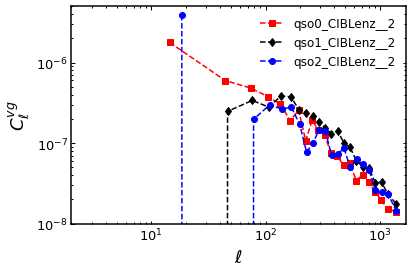

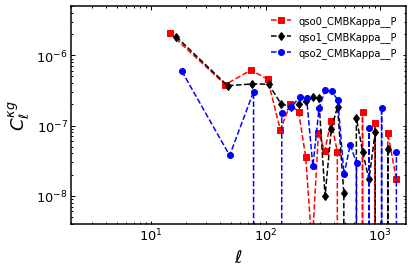

In [10]:
## PLOT CHECK ##
plt.loglog(leff, cls['qso0_CIBLenz__2']['cl'][0], 'rs', label = 'qso0_CIBLenz__2', ls = '--')
plt.plot(leff+2, cls['qso1_CIBLenz__2']['cl'][0], 'kd', label = 'qso1_CIBLenz__2', ls = '--')
plt.plot(leff+4, cls['qso2_CIBLenz__2']['cl'][0], 'bo',  label = 'qso2_CIBLenz__2', ls = '--')
plt.legend(loc = 'best', fontsize = 12, frameon = False)

plt.loglog(leff, cls['qso0_CMBKappa__P']['cl'][0], 'rs', label = 'qso0_CMBKappa__P', ls = '--')
plt.plot(leff+2, cls['qso1_CMBKappa__P']['cl'][0], 'kd', label = 'qso1_CMBKappa__P', ls = '--')
plt.plot(leff+4, cls['qso2_CMBKappa__P']['cl'][0], 'bo',  label = 'qso2_CMBKappa__P', ls = '--')
plt.legend(loc = 'best', fontsize = 10, frameon = False)

In [25]:
## computing the total covariance considering: 3 cross spectrum and 3 auto spectrum (no gigj) ##
cws = {}
## work around since get mask is not working
masks_all = {'qso0': masks['qso0'], 'qso1': masks['qso1'], 'qso2': masks['qso2'], 'CIBLenz__2': mask_c, 'CMBKappa__P': mask_l}

def get_cov(f1, f2, f3, f4, ms, w12, w34):
    nm = f'{f1.sel}-{f2.sel}-{f3.sel}-{f4.sel}'
    fs = [f1, f2, f3, f4]
    # ms = [f.get_mask() for f in fs]
    #ms = [mask_bin1, mask_bin2, mask_c, mask_c]
    cls = np.array([[nmt.compute_coupled_cell(fs[i], fs[j])/np.mean(ms[i]*ms[j])
                     for i in range(4)] for j in range(4)])
    cw = nmt.NmtCovarianceWorkspace()
    cw.compute_coupling_coefficients(f1, f2, f3, f4)
    cws[nm] = cw
    cv = nmt.gaussian_covariance(cw, 0, 0, 0, 0, cls[0, 2], cls[0, 3], cls[1, 2], cls[1, 3], w12, wb=w34)
    return cv

In [ ]:
n_cls = (nbins+1)*((nbins)+3)//2
n_ell = len(cls['qso0_qso0']['cl'][0])


In [42]:
cov = []
for i1, _, _, _, _, _ in cl_iter():
    cov.append([])
    for i2, _, _, _, _, _ in cl_iter():
        cov[i1].append(np.zeros([n_ell, n_ell]))

for icl1, _, _, nm1, nm2, cl_name12 in cl_iter():
    f1 = fgs[nm1]
    f2 = fgs[nm2]
    # print('nm1', nm1, 'nm2', nm2)
    w12 = cls[cl_name12]['w']
    for icl2, _, _, nm3, nm4, cl_name34 in cl_iter():
        #print(nm1, nm2, nm3, nm4)
        f3 = fgs[nm3]
        f4 = fgs[nm4]
        # print('nm3', nm3, 'nm4', nm4)
        w34 = cls[cl_name34]['w']
        ms = [masks_all[nm] for nm in [nm1, nm2, nm3, nm4]]
        if icl2 < icl1:
            cv = cov[icl2][icl1].T
        else:
            cv = get_cov(f1, f2, f3, f4, ms, w12, w34)
        if icl1 == icl2:
            # gg-gg auto cov. Deproject shot noise.
            if (nm1 == nm2) and (Asn_prior is not None):
                nl = cls[cl_name12]['nl'].squeeze()
                cv += Asn_prior**2*np.outer(nl, nl)
            cls[cl_name12]['cov'] = cv
        cov[icl1][icl2] = cv
cov_blocks = np.array(cov)
cov_all = np.transpose(cov_blocks, axes=[0, 2, 1, 3]).reshape([n_cls*n_ell, n_cls*n_ell])

In [ ]:
## saving into a Sacc file ##
s = sacc.Sacc()
ls = np.arange(3*nside)
bm = np.ones(3*nside)

i = 0
for nm in map_names[:-2]:
    print(nm)
    nz = nzs[i]
    s.add_tracer('NZ', nm, quantity='galaxy_density', spin=0, z= z, nz=nz)
    i+=1

s.add_tracer('Map', 'CIBLenz__2', quantity='cib', spin=0, ell=ls, beam=bm)
s.add_tracer('Map', 'CMBKappa__P', quantity='cmb', spin=0, ell=ls, beam=bm)

for icl1, _, _, nm1, nm2, cl_name in cl_iter():
    d = cls[cl_name]
    s.add_ell_cl('cl_00', nm1, nm2, leff,
                 d['cl'].squeeze(),
                 window=sacc.BandpowerWindow(ls, d['Bbl'].T))
s.add_covariance(cov_all)
fname = f"cls_g_cib_{nbins}bins_G{magcut}_logbins3_allfield"
s.save_fits(dir +fname+".fits", overwrite=True)